<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 80px">

# Project 3: Part 2
# EDA & Data Cleaning

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from matplotlib_venn import venn2
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
pd.options.mode.chained_assignment = None 

%matplotlib inline
sns.set()

-----------

In [2]:
#Load both Marvel & DC dataset
df_marvel = pd.read_csv('marvelstudios.csv')
df_dc = pd.read_csv('DC_Cinematic.csv')

## Cleaning both DataSets

### Marvel Data

In [3]:
df_marvel.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_background_color,author_flair_css_class,author_flair_text,author_flair_text_color,awarders,can_mod_post,...,edited,discussion_type,media_embed,secure_media_embed,gallery_data,media_metadata,banned_by,gilded,author_cakeday,poll_data
0,0,[],False,[deleted],NaN,NaN,NaN,dark,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,mackey_00,NaN,widow2,Black Widow (Avengers),dark,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,Tsujigiri,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,FoibleFox,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,ThaShadowX,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_marvel.shape

(1100, 85)

In [5]:
#Checking for duplicates
df_marvel.drop_duplicates(['id'], inplace = True)

In [6]:
df_marvel.shape

(1100, 85)

In [7]:
df_marvel.columns

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_text', 'author_flair_text_color', 'awarders',
       'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link',
       'gildings', 'id', 'is_created_from_ads_ui', 'is_crosspostable',
       'is_gallery', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers',

As we are looking into classifying between two different subreddits, we will be more interested with the content within each posts

Those non-relevant to content will be dropped to reduce amount of noise found within the later training set

In [8]:
#Choosing the relevant columns
df_marvel_new = df_marvel[['author_flair_css_class','author_flair_text','full_link'
                           ,'link_flair_text','permalink', 'selftext'
                           , 'subreddit', 'title' ]]

#### Checking for Null Values

In [9]:
df_marvel_new.isnull().sum()

author_flair_css_class    936
author_flair_text         937
full_link                   0
link_flair_text             3
permalink                   0
selftext                  546
subreddit                   0
title                       0
dtype: int64

In [10]:
df_marvel_new[['author_flair_css_class','author_flair_text','link_flair_text','selftext']]

,author_flair_css_class,author_flair_text,link_flair_text,selftext
0,NaN,NaN,Discussion,[deleted]
1,widow2,Black Widow (Avengers),Behind the Scenes,NaN
2,NaN,NaN,'Loki' Spoilers,NaN
3,NaN,NaN,Humour,NaN
4,NaN,NaN,Discussion,I personally do not know much about this chara...
...,...,...,...,...
1095,NaN,NaN,Clips,NaN
1096,NaN,NaN,Fan Art/Content,NaN
1097,NaN,NaN,Discussion,Where are you guys watching it?
1098,NaN,NaN,Promotional,Just got mine through AMC.


##### Imputing missing values with an empty space

In [11]:
df_marvel_new['author_flair_css_class'].fillna(' ',inplace=True)
df_marvel_new['author_flair_text'].fillna(' ',inplace=True)
df_marvel_new['link_flair_text'].fillna(' ',inplace=True)
df_marvel_new['selftext'].fillna(' ',inplace=True)

In [12]:
df_marvel_new.isnull().sum()

author_flair_css_class    0
author_flair_text         0
full_link                 0
link_flair_text           0
permalink                 0
selftext                  0
subreddit                 0
title                     0
dtype: int64

------------

#### Checking and Cleaning individual Features

<u>Columns used for Marvel </u>

- author_flair_css_class
- author_flair_text 
- full_link 
- link_flair_text 
- permalink 
- selftext
- subreddit
- title

In [13]:
df_marvel_new['author_flair_css_class'].unique()

array([' ', 'widow2', 'wardmeachum', 'dd2', 'strange', 'Korg', 'coulsen',
       'zemo', 'groot', 'SMhomecoming', 'Valkyrie1', 'vision',
       'blackpanter', 'thanos2', 'thanos', 'robbie', 'avengers', 'tony',
       'loki3', 'spidey', 'jimmywoo', 'Hela2', 'wsoldier', 'quill',
       'babygroot', 'crossbones', 'yondu', 'markXLIII', 'Feige',
       'murdock', 'BlackBolt', 'Valkyrie2', 'switch', 'lang', 'rocket',
       'thanos3', 'hydra', 'markII', 'hawk1', 'gamora', 'yinsen',
       'antman3', 'Grandmaster', 'spiderman', 'frigga', 'peter', 'nebula',
       'warmachine2', 'daisy', 'Hela1', 'hulk3', 'cap3', 'Michelle',
       'ironpatriot', 'bucky', 'bucky2', 'elektra', 'capmar1', 'markI',
       'cap7', 'rogers', 'dd1', 'fitz', 'ghostrider', 'Shuri', 'starlord',
       'cap1'], dtype=object)

Some values appear to have numbers at the end of the words

To remove these numbers, I will use RegEx to find only letters and to join them back to make the words.

In [14]:
for i in df_marvel_new.index:
    df_marvel_new['author_flair_css_class'][i] = " ".join(re.findall("[a-zA-Z]+", df_marvel_new['author_flair_css_class'][i]))


In [15]:
df_marvel_new['author_flair_css_class'].unique()

array(['', 'widow', 'wardmeachum', 'dd', 'strange', 'Korg', 'coulsen',
       'zemo', 'groot', 'SMhomecoming', 'Valkyrie', 'vision',
       'blackpanter', 'thanos', 'robbie', 'avengers', 'tony', 'loki',
       'spidey', 'jimmywoo', 'Hela', 'wsoldier', 'quill', 'babygroot',
       'crossbones', 'yondu', 'markXLIII', 'Feige', 'murdock',
       'BlackBolt', 'switch', 'lang', 'rocket', 'hydra', 'markII', 'hawk',
       'gamora', 'yinsen', 'antman', 'Grandmaster', 'spiderman', 'frigga',
       'peter', 'nebula', 'warmachine', 'daisy', 'hulk', 'cap',
       'Michelle', 'ironpatriot', 'bucky', 'elektra', 'capmar', 'markI',
       'rogers', 'fitz', 'ghostrider', 'Shuri', 'starlord'], dtype=object)

After clearing the numbers, I can see that each words makes better sense

In [16]:
df_marvel_new['author_flair_text'].unique()

array([' ', 'Black Widow (Avengers)', 'Ward Meachum', 'Daredevil',
       'Doctor Strange', 'Korg', 'Phil Coulson', 'Zemo', 'Groot',
       'Spider-Man', 'Valkyrie', 'Vision', 'Black Panther', 'Thanos',
       'Robbie Reyes', 'Avengers', 'Tony Stark', 'Loki (Avengers)',
       'Jimmy Woo', 'Hela', 'Winter Soldier', 'Peter Quill', 'Baby Groot',
       'Crossbones', 'Yondu', 'Iron Man (Mark XLIII)', 'Kevin Feige',
       'Matt Murdock', 'Black Bolt', 'Scarlet Witch', 'Scott Lang',
       'Rocket', 'Hydra', 'Iron Man (Mark II)', 'Hawkeye (Avengers)',
       'Gamora', 'Yinsen', 'Ant-Man', 'Grandmaster', 'Frigga',
       'Peter Parker', 'Nebula', 'War Machine', 'Daisy Johnson', 'Hulk',
       'Captain America', 'Michelle', 'Iron Patriot', 'Bucky', 'Elektra',
       'Captain Marvel', 'Iron man (Mark I)', 'Captain America (Ultron)',
       'Steve Rogers', 'Fitz', 'Ghost Rider', 'Shuri', 'Star-Lord'],
      dtype=object)

Nothing out of the ordinary for 'author_flair_text' column

In [17]:
df_marvel_new['full_link'].unique()

array(['https://www.reddit.com/r/marvelstudios/comments/o0rw82/rewatching_is_very_different_after_endgame_now_i/',
       'https://www.reddit.com/r/marvelstudios/comments/o0rw7m/on_set_of_black_widow_with_scarlett_johansson_and/',
       'https://www.reddit.com/r/marvelstudios/comments/o0rulg/sorry_if_im_late_to_the_game_but_is_that_a/',
       ...,
       'https://www.reddit.com/r/marvelstudios/comments/nxg2gm/black_widow_disney_or_in_theaters/',
       'https://www.reddit.com/r/marvelstudios/comments/nxg1wm/fyi_black_widow_tickets_are_now_on_sale/',
       'https://www.reddit.com/r/marvelstudios/comments/nxg1uy/black_magneto_how_about_we_expand_on_existing/'],
      dtype=object)

Words at the end of the string will be important data for the upcoming Train/Test.

In [18]:
for i in df_marvel_new.index:
    x = df_marvel_new['full_link'][i].split('/')
    df_marvel_new['full_link'][i] = x[7].replace('_',' ')

In [19]:
df_marvel_new['full_link'].unique()

array(['rewatching is very different after endgame now i',
       'on set of black widow with scarlett johansson and',
       'sorry if im late to the game but is that a', ...,
       'black widow disney or in theaters',
       'fyi black widow tickets are now on sale',
       'black magneto how about we expand on existing'], dtype=object)

After splitting and replacing, words are more readable for use.

In [20]:
df_marvel_new['link_flair_text'].unique()

array(['Discussion', 'Behind the Scenes', "'Loki' Spoilers", 'Humour',
       'Articles', 'Fan Art/Content', 'Question', 'REMOVED: REPOST',
       'REMOVED:UNRELIABLE SOURCE/RUMOUR',
       "'Thor: Love &amp; Thunder' Spoilers",
       'REMOVED: LOW EFFORT POST/MEME', 'Theory', 'Other',
       "'Spider-Man: No Way Home ' Spoilers", 'Spoilers!', 'Clips',
       'Promotional', 'Concept Art', 'REMOVED: UNRELATED TO MCU',
       'Rumours', ' ',
       'REMOVED: Misleading Content. An Actor included is only rumoured ',
       'Merchandise', "'Falcon &amp; TWS' Spoilers", 'Epic Rant',
       'REMOVED', "'She Hulk' Spoilers", "'Black Widow' Spoilers",
       "'Hawkeye' Spoilers", "'Doctor Strange:MoM' Spoilers"],
      dtype=object)

Certain words contain '&amp' which represent the symbol '&'.

For readability, I will be replacing '&amp' with 'and'

In [21]:
df_marvel_new['link_flair_text'] = df_marvel_new['link_flair_text'].replace('\'Thor: Love &amp; Thunder\' Spoilers'
                                                                            ,'Thor: Love and Thunder\' Spoilers')

In [22]:
df_marvel_new['link_flair_text'] = df_marvel_new['link_flair_text'].replace('\'Falcon &amp; TWS\' Spoilers'
                                                                            ,'\'Falcon and TWS\' Spoilers')

In [23]:
df_marvel_new['link_flair_text'].unique()

array(['Discussion', 'Behind the Scenes', "'Loki' Spoilers", 'Humour',
       'Articles', 'Fan Art/Content', 'Question', 'REMOVED: REPOST',
       'REMOVED:UNRELIABLE SOURCE/RUMOUR',
       "Thor: Love and Thunder' Spoilers",
       'REMOVED: LOW EFFORT POST/MEME', 'Theory', 'Other',
       "'Spider-Man: No Way Home ' Spoilers", 'Spoilers!', 'Clips',
       'Promotional', 'Concept Art', 'REMOVED: UNRELATED TO MCU',
       'Rumours', ' ',
       'REMOVED: Misleading Content. An Actor included is only rumoured ',
       'Merchandise', "'Falcon and TWS' Spoilers", 'Epic Rant', 'REMOVED',
       "'She Hulk' Spoilers", "'Black Widow' Spoilers",
       "'Hawkeye' Spoilers", "'Doctor Strange:MoM' Spoilers"],
      dtype=object)

In [24]:
df_marvel_new['permalink'].unique()

array(['/r/marvelstudios/comments/o0rw82/rewatching_is_very_different_after_endgame_now_i/',
       '/r/marvelstudios/comments/o0rw7m/on_set_of_black_widow_with_scarlett_johansson_and/',
       '/r/marvelstudios/comments/o0rulg/sorry_if_im_late_to_the_game_but_is_that_a/',
       ...,
       '/r/marvelstudios/comments/nxg2gm/black_widow_disney_or_in_theaters/',
       '/r/marvelstudios/comments/nxg1wm/fyi_black_widow_tickets_are_now_on_sale/',
       '/r/marvelstudios/comments/nxg1uy/black_magneto_how_about_we_expand_on_existing/'],
      dtype=object)

Similar to column 'full_link', words on the end of the string will be usefull for Train/Test

In [25]:
for i in df_marvel_new.index:
    x = df_marvel_new['permalink'][i].split('/')
    df_marvel_new['permalink'][i] = x[5].replace('_',' ')

In [26]:
df_marvel_new['permalink'].unique()

array(['rewatching is very different after endgame now i',
       'on set of black widow with scarlett johansson and',
       'sorry if im late to the game but is that a', ...,
       'black widow disney or in theaters',
       'fyi black widow tickets are now on sale',
       'black magneto how about we expand on existing'], dtype=object)

In [27]:
df_marvel_new['subreddit'].unique()

array(['marvelstudios'], dtype=object)

This will be used for our labels

In [28]:
df_marvel_new['selftext'].unique()

array(['[deleted]', ' ',
       'I personally do not know much about this character but i think he is very cool from the little i do know. I like that he will bring in a new mythology to the MCU and that he is schizophrenic. I am really excited to see how they will adapt that into a live action series. And while i dont know the characters that could appear in the show doing a little research i find that Spiderman, Daredevil and She-Hulk could appear. This is really just me seeing what the community thinks about the character getting a show.',
       'I’ve been thinking of this a lot and I don’t know if it’s been discussed before, but if Tony snapped his fingers, sacrificing himself and his future to save the world, he should’ve been worthy. Granting him the powers of Thor and the ability to wield Mjolnir (which has proven to have healing capabilities), why did he not use that to save himself from dying? \n\nAm I overthinking it? He should be worthy, he gave up the chance of staying hap

In [29]:
for i in df_marvel_new.index:
    df_marvel_new['selftext'][i] = df_marvel_new['selftext'][i].replace('_',' ')

'selftext' column houses alot of words. Basic cleaning would involve replacing any '_' with an empty space

In [30]:
df_marvel_new['title'].unique()

array(['Rewatching is very different after Endgame. Now I see all the references to the infinity stones. This picture is from Thor: TDW. I can see red, green, purple, yellow, blue and orange.',
       "On Set of 'Black Widow' With Scarlett Johansson and Florence Pugh",
       "Sorry if I'm late to the game, but is that a bilgesnipe?", ...,
       'BLACK WIDOW - Disney + or In Theaters?',
       'FYI Black Widow🕷 tickets are now on sale.',
       'Black Magneto - how about we expand on existing Black supers instead of changing backstories?'],
      dtype=object)

Nothing out of the ordinary for 'title' column

##### Creating a Clean Marvel Dataset to use for EDA and Modelling

In [31]:
df_marvel_new.head(1)

,author_flair_css_class,author_flair_text,full_link,link_flair_text,permalink,selftext,subreddit,title
0,,,rewatching is very different after endgame now i,Discussion,rewatching is very different after endgame now i,[deleted],marvelstudios,Rewatching is very different after Endgame. No...


From the cleaned data. Both "full_link" and "permalink" looks to be duplicated. As such, I will only be using "full_link"

In [32]:
df_marvel_new['combined'] = df_marvel_new['author_flair_css_class'] + df_marvel_new['author_flair_text'] + ' ' + df_marvel_new['full_link'] + ' ' + df_marvel_new['link_flair_text'] + ' ' + df_marvel_new['selftext'] + ' ' + df_marvel_new['title'] 

In [33]:
df_marvel_new['combined'] = df_marvel_new['combined'].str.replace(r'[^\x00-\x7F]+', '')

In [34]:
df_marvel_new.head(1)

,author_flair_css_class,author_flair_text,full_link,link_flair_text,permalink,selftext,subreddit,title,combined
0,,,rewatching is very different after endgame now i,Discussion,rewatching is very different after endgame now i,[deleted],marvelstudios,Rewatching is very different after Endgame. No...,rewatching is very different after endgame n...


In [35]:
df_marvel_clean = df_marvel_new.drop(columns=['author_flair_css_class','author_flair_text'
                                     ,'full_link','link_flair_text','permalink','selftext','title'])

In [36]:
df_marvel_clean

,subreddit,combined
0,marvelstudios,rewatching is very different after endgame n...
1,marvelstudios,widowBlack Widow (Avengers) on set of black wi...
2,marvelstudios,sorry if im late to the game but is that a '...
3,marvelstudios,a jeopardy contestant guessed thor ragnarok ...
4,marvelstudios,the moon knight show what do yall think of i...
...,...,...
1095,marvelstudios,black panther run boy run Clips Black Pant...
1096,marvelstudios,i put together some of the letters from the ...
1097,marvelstudios,black widow disney or in theaters Discussion...
1098,marvelstudios,fyi black widow tickets are now on sale Prom...


In [37]:
df_marvel_clean.head(1)

,subreddit,combined
0,marvelstudios,rewatching is very different after endgame n...


### DC_Cinematic Data

In [38]:
df_dc.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_background_color,author_flair_css_class,author_flair_text,author_flair_text_color,awarders,can_mod_post,...,secure_media,media_embed,secure_media_embed,banned_by,gallery_data,media_metadata,author_cakeday,edited,gilded,poll_data
0,0,[],False,[deleted],NaN,NaN,NaN,dark,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Samoht99,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"[{'award_sub_type': 'GLOBAL', 'award_type': 'g...",False,dtn_06,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,[deleted],NaN,NaN,NaN,dark,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Hangman963,NaN,NaN,NaN,NaN,[],False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_dc.shape

(1100, 84)

In [40]:
#Checking for duplicates
df_dc.drop_duplicates(['id'], inplace = True)

In [41]:
df_dc.shape

(1100, 84)

In [42]:
df_dc.columns

Index(['Unnamed: 0', 'all_awardings', 'allow_live_comments', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_text', 'author_flair_text_color', 'awarders',
       'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link',
       'gildings', 'id', 'is_created_from_ads_ui', 'is_crosspostable',
       'is_meta', 'is_original_content', 'is_reddit_media_domain',
       'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_text', 'link_flair_text_color',
       'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail',
       'thumbna

In [43]:
df_dc_new = df_dc[['author_flair_css_class','author_flair_text','full_link'
                  ,'permalink','selftext','subreddit','title']]

#### Checking for Null Values

In [44]:
df_dc_new.isnull().sum()

author_flair_css_class     998
author_flair_text         1052
full_link                    0
permalink                    0
selftext                   850
subreddit                    0
title                        0
dtype: int64

##### Imputing missing values with an empty space

In [45]:
df_dc_new['author_flair_css_class'].fillna(' ',inplace = True)
df_dc_new['author_flair_text'].fillna(' ',inplace=True)
df_dc_new['selftext'].fillna(' ',inplace=True)

In [46]:
df_dc_new.isnull().sum()

author_flair_css_class    0
author_flair_text         0
full_link                 0
permalink                 0
selftext                  0
subreddit                 0
title                     0
dtype: int64

#### Checking and Cleaning individual Features

<u>Columns used for DC </u>

- author_flair_css_class 
- author_flair_text 
- full_link 
- permalink
- selftext
- subreddit
- title

In [47]:
df_dc_new['author_flair_css_class'].unique()

array([' ', 'batman2', 'tacbatman', 'parademon', 'deathstroke',
       'armorbat', 'supermananimated', 'superman', 'dktwoface',
       'batmananimated', 'shazam2', 'joker', 'superman2', 'knightmare',
       'loislane', 'thedarkknight', 'batman', 'harleytat', 'freddyshazam',
       'drmanhattan', 'bvs2', 'AQaquaman', 'chief', 'rickflagtat',
       'arthurcurry', 'cyborganimated', 'brucewayne', 'glc',
       'justiceleague', 'jlshield', 'batmanbruce'], dtype=object)

In [48]:
for i in df_dc_new.index:
    df_dc_new['author_flair_css_class'][i] = " ".join(re.findall("[a-zA-Z]+", df_dc_new['author_flair_css_class'][i]))


In [49]:
df_dc_new['author_flair_css_class'].unique()

array(['', 'batman', 'tacbatman', 'parademon', 'deathstroke', 'armorbat',
       'supermananimated', 'superman', 'dktwoface', 'batmananimated',
       'shazam', 'joker', 'knightmare', 'loislane', 'thedarkknight',
       'harleytat', 'freddyshazam', 'drmanhattan', 'bvs', 'AQaquaman',
       'chief', 'rickflagtat', 'arthurcurry', 'cyborganimated',
       'brucewayne', 'glc', 'justiceleague', 'jlshield', 'batmanbruce'],
      dtype=object)

Nothing out of the ordinary for 'author_flair_css_class' column

In [50]:
df_dc_new['full_link'].unique()

array(['https://www.reddit.com/r/DC_Cinematic/comments/o0rytu/social_media_the_rock_says_cool_thing_dropping/',
       'https://www.reddit.com/r/DC_Cinematic/comments/o0r1hd/article_in_treatment_star_quintessa_swindell_on/',
       'https://www.reddit.com/r/DC_Cinematic/comments/o0qbro/humor_i_posted_this_earlier_but_forgot_to_flair_it/',
       ...,
       'https://www.reddit.com/r/DC_Cinematic/comments/nqgmiq/discussion_which_actor_do_you_think_looks_the/',
       'https://www.reddit.com/r/DC_Cinematic/comments/nqflow/question_would_you_die_for_me_no_but_seriously/',
       'https://www.reddit.com/r/DC_Cinematic/comments/nqfk3q/fanmade_the_flash_pwnisher_alternate_realities/'],
      dtype=object)

In [51]:
for i in df_dc_new.index:
    x = df_dc_new['full_link'][i].split('/')
    df_dc_new['full_link'][i] = x[7].replace('_',' ')

In [52]:
df_dc_new['full_link'].unique()

array(['social media the rock says cool thing dropping',
       'article in treatment star quintessa swindell on',
       'humor i posted this earlier but forgot to flair it', ...,
       'discussion which actor do you think looks the',
       'question would you die for me no but seriously',
       'fanmade the flash pwnisher alternate realities'], dtype=object)

In [53]:
df_dc_new['permalink'].unique()

array(['/r/DC_Cinematic/comments/o0rytu/social_media_the_rock_says_cool_thing_dropping/',
       '/r/DC_Cinematic/comments/o0r1hd/article_in_treatment_star_quintessa_swindell_on/',
       '/r/DC_Cinematic/comments/o0qbro/humor_i_posted_this_earlier_but_forgot_to_flair_it/',
       ...,
       '/r/DC_Cinematic/comments/nqgmiq/discussion_which_actor_do_you_think_looks_the/',
       '/r/DC_Cinematic/comments/nqflow/question_would_you_die_for_me_no_but_seriously/',
       '/r/DC_Cinematic/comments/nqfk3q/fanmade_the_flash_pwnisher_alternate_realities/'],
      dtype=object)

In [54]:
for i in df_dc_new.index:
    x = df_dc_new['permalink'][i].split('/')
    df_dc_new['permalink'][i] = x[5].replace('_',' ')

In [55]:
df_dc_new['permalink'].unique()

array(['social media the rock says cool thing dropping',
       'article in treatment star quintessa swindell on',
       'humor i posted this earlier but forgot to flair it', ...,
       'discussion which actor do you think looks the',
       'question would you die for me no but seriously',
       'fanmade the flash pwnisher alternate realities'], dtype=object)

In [56]:
df_dc_new['selftext'].unique()

array(['[deleted]', ' ',
       '[removed]\n\n[View Poll](https://www.reddit.com/poll/o0pdhx)',
       'I screen recorded Batman v superman and wanted to get this screenshot but couldn’t quite do it just with slowing it down in iMovie, is there a better version somewhere?\n\nhttps://imgur.com/gallery/frNBGNv',
       '[removed]',
       'And if so would Black Adam be an old god since he was around in ancient times?',
       "Question in title, I pad for a month of the crappy streaming quality you can get on hbo max but I'd like the actual disc. Where can I buy it in the US? Thanks!",
       'https://m.youtube.com/watch?v=R-_HIIhLS6M\n\nI remember finding on some fan site like 20 years ago and could never find it again. Randomly it was recommended during some YT browsing this morning. \n\nThis is the voiceover guy they used for all the trailers and spots and you can tell he was sick of the over the top selling of the film as The Second Coming.',
       "To confess, when I watched Batman

In [57]:
for i in df_dc_new.index:
    df_dc_new['selftext'][i] = df_dc_new['selftext'][i].replace('_',' ')

In [58]:
df_dc_new['subreddit'].unique()

array(['DC_Cinematic'], dtype=object)

In [59]:
df_dc_new['title'].unique()

array(['Social Media: The Rock says Cool thing dropping tomorrow',
       "ARTICLE: 'In Treatment' Star Quintessa Swindell on Exploring the Realism of 'Black Adam'",
       'HUMOR: I posted this earlier but forgot to flair it', ...,
       'Discussion: Which actor do you think *looks* the most like Bruce Wayne would?',
       'Question, would you die for me? No but seriously how do y’all feel about Harley and joker pairing? Would you prefer Harley and ivy for the dceu?',
       'FAN-MADE: The Flash - Pwnisher Alternate Realities Render Challenge'],
      dtype=object)

##### Creating a Clean Marvel Dataset to use for EDA and Modelling

In [60]:
df_dc_new.head(1)

,author_flair_css_class,author_flair_text,full_link,permalink,selftext,subreddit,title
0,,,social media the rock says cool thing dropping,social media the rock says cool thing dropping,[deleted],DC_Cinematic,Social Media: The Rock says Cool thing droppin...


Similarly seen here, 'full_link' and 'permalink' are similar. Therefore, I will be taking only 'full_link'

In [61]:
df_dc_new['combined'] = df_dc_new['author_flair_css_class'] + ' ' + df_dc_new['author_flair_text'] + ' ' + df_dc_new['full_link'] + ' ' + df_dc_new['selftext'] + ' '  + df_dc_new['title'] 

In [62]:
df_dc_new['combined'] = df_dc_new['combined'].str.replace(r'[^\x00-\x7F]+', '')

In [63]:
df_dc_new.head(1)

,author_flair_css_class,author_flair_text,full_link,permalink,selftext,subreddit,title,combined
0,,,social media the rock says cool thing dropping,social media the rock says cool thing dropping,[deleted],DC_Cinematic,Social Media: The Rock says Cool thing droppin...,social media the rock says cool thing dropp...


In [64]:
df_dc_clean = df_dc_new.drop(columns = ['author_flair_css_class','author_flair_text'
                                        ,'full_link','permalink','selftext','title'])

In [65]:
df_dc_clean.head(1)

,subreddit,combined
0,DC_Cinematic,social media the rock says cool thing dropp...


---------------

### Mapping Marvel and DC 

In [66]:
df_marvel_clean['subreddit'] = df_marvel_clean['subreddit'].map({'marvelstudios' : 1})

In [67]:
df_marvel_clean.head(1)

,subreddit,combined
0,1,rewatching is very different after endgame n...


In [68]:
df_dc_clean['subreddit'] = df_dc_clean['subreddit'].map({'DC_Cinematic' : 0})

In [69]:
df_dc_clean.head(1)

,subreddit,combined
0,0,social media the rock says cool thing dropp...


-------------

## EDA

------

### Exploring Marvel Dataset

In [70]:
# Instantiate tokenizer.
tokenizer = RegexpTokenizer(r"\w+[a-zA-Z]")
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()
# Instantiate Stopwords
stopwords = stopwords.words('english')

In [71]:
#Tokenize and store
df_marvel_clean["tokens"] = df_marvel_clean["combined"].apply(tokenizer.tokenize)

#### Stemming Vs Lemmatizing

In [72]:
#Creating a Lemmatized column

lem_array = []
for i in df_marvel_clean.index:
    lem_list = []
    for x in df_marvel_clean["tokens"][i]:
        lem_list.append(lemmatizer.lemmatize(x).lower())
    lem_array.append(lem_list)

df_marvel_clean['lem'] = lem_array

#Creating a Stemmatized column

stem_array = []
for c in df_marvel_clean.index:
    stem_list = []
    for w in df_marvel_clean["tokens"][c]:
        stem_list.append(p_stemmer.stem(w).lower())
    stem_array.append(stem_list)

df_marvel_clean['stem'] = stem_array

In [73]:
#Comparing Stemmatized and Lemmatized Tokens

list(zip(df_marvel_clean['stem'][0], df_marvel_clean['lem'][0]))

[('rewatch', 'rewatching'),
 ('is', 'is'),
 ('veri', 'very'),
 ('differ', 'different'),
 ('after', 'after'),
 ('endgam', 'endgame'),
 ('now', 'now'),
 ('discuss', 'discussion'),
 ('delet', 'deleted'),
 ('rewatch', 'rewatching'),
 ('is', 'is'),
 ('veri', 'very'),
 ('differ', 'different'),
 ('after', 'after'),
 ('endgam', 'endgame'),
 ('now', 'now'),
 ('see', 'see'),
 ('all', 'all'),
 ('the', 'the'),
 ('refer', 'reference'),
 ('to', 'to'),
 ('the', 'the'),
 ('infin', 'infinity'),
 ('stone', 'stone'),
 ('thi', 'this'),
 ('pictur', 'picture'),
 ('is', 'is'),
 ('from', 'from'),
 ('thor', 'thor'),
 ('tdw', 'tdw'),
 ('can', 'can'),
 ('see', 'see'),
 ('red', 'red'),
 ('green', 'green'),
 ('purpl', 'purple'),
 ('yellow', 'yellow'),
 ('blue', 'blue'),
 ('and', 'and'),
 ('orang', 'orange')]

In [74]:
#Finding odd words out
comparison = set(df_marvel_clean['stem'][0]) - set(df_marvel_clean['lem'][0])
print(comparison)

{'pictur', 'rewatch', 'purpl', 'differ', 'refer', 'delet', 'thi', 'orang', 'discuss', 'endgam', 'infin', 'veri'}


From the comparison below between Stemmatizer and Lemmatizer. I can see some words within the Stemmatizer does not actually mean real words

|Stemmatized Words|Lemmatized Words|
|--|--|
|delet|deleted|
|differ|different|
|discuss|Discussion|
|endgam|Endgame|
|infin|infinity|
|orang|orange|
|pictur|picture|
|purpl|purple|
|refer|reference|
|rewatch|rewatching|
|thi|This|
|veri|very|

As such, I would not advise to use stemmatized words as we are trying to predict words from a specific reddit. Such odd words will confuse the user to look at the highest coefficient word in the upcoming modelling phase

In [75]:
# Drop Stemmed Columns
df_marvel_clean.drop('stem',axis = 1, inplace = True)

#### Word Frequency

In [76]:
#Creating a combined list of words through all elements
marvel_freq_count = []

for i in df_marvel_clean['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        marvel_freq_count.append(x)

In [77]:
#Finding words with highest frequency
marvel_word_freq = FreqDist(marvel_freq_count)
print(marvel_word_freq.most_common(10))

[('loki', 1260), ('time', 545), ('tva', 467), ('timeline', 426), ('wa', 385), ('like', 333), ('mcu', 310), ('one', 272), ('think', 259), ('would', 256)]


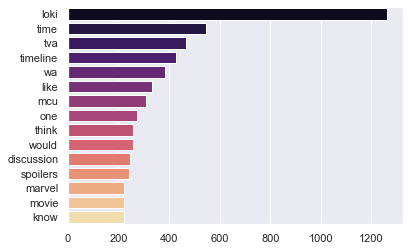

In [78]:
#Top 15 words
marvel_top_fifteen = marvel_word_freq.most_common(15)
words_marvel= [x[0] for x in marvel_top_fifteen]
count_marvel= [x[1] for x in marvel_top_fifteen]

sns.barplot(x =count_marvel, y =words_marvel, palette= 'magma');

Some words are very generic and are highly likely to be found in the DC_Cinematic reddit. These words don't represent any heroes and are just standard english words.

Removing them would be a good idea to improve the accuracy of our model

In [79]:
#Adding words into the stopword
new_words=('wa','like','think','would','discussion','know')
for i in new_words:
    stopwords.append(i)

In [80]:
#Creating a combined list of words through all elements
marvel_freq_count = []

for i in df_marvel_clean['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        marvel_freq_count.append(x)

In [81]:
#Finding words with highest frequency
marvel_word_freq = FreqDist(marvel_freq_count)
print(marvel_word_freq.most_common(10))

[('loki', 1260), ('time', 545), ('tva', 467), ('timeline', 426), ('mcu', 310), ('one', 272), ('spoilers', 241), ('marvel', 223), ('movie', 223), ('see', 219)]


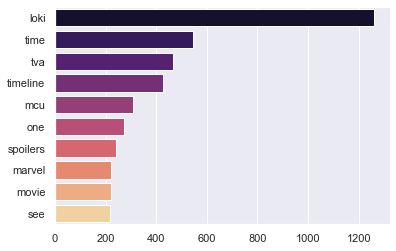

In [82]:
#Top 10 words
marvel_top_ten = marvel_word_freq.most_common(10)
words_marvel= [x[0] for x in marvel_top_ten]
count_marvel= [x[1] for x in marvel_top_ten]

sns.barplot(x =count_marvel, y =words_marvel, palette= 'magma');

Top ten words looks promising and from my understanding of Marvel, majority of these words are recorgnizable as only for Marvel

### Exploring DC Dataset

In [83]:
#Tokenize and store
df_dc_clean["tokens"] = df_dc_clean["combined"].apply(tokenizer.tokenize)

In [84]:
#Creating a Lemmatized column

lem_array = []
for i in df_dc_clean.index:
    lem_list = []
    for x in df_dc_clean["tokens"][i]:
        lem_list.append(lemmatizer.lemmatize(x).lower())
    lem_array.append(lem_list)

df_dc_clean['lem'] = lem_array

#Creating a Stemmatized column

stem_array = []
for c in df_dc_clean.index:
    stem_list = []
    for w in df_dc_clean["tokens"][c]:
        stem_list.append(p_stemmer.stem(w).lower())
    stem_array.append(stem_list)

df_dc_clean['stem'] = stem_array

In [85]:
#Comparing Stemmatized and Lemmatized Tokens

list(zip(df_dc_clean['stem'][0], df_dc_clean['lem'][0]))

[('social', 'social'),
 ('media', 'medium'),
 ('the', 'the'),
 ('rock', 'rock'),
 ('say', 'say'),
 ('cool', 'cool'),
 ('thing', 'thing'),
 ('drop', 'dropping'),
 ('delet', 'deleted'),
 ('social', 'social'),
 ('media', 'media'),
 ('the', 'the'),
 ('rock', 'rock'),
 ('say', 'say'),
 ('cool', 'cool'),
 ('thing', 'thing'),
 ('drop', 'dropping'),
 ('tomorrow', 'tomorrow')]

In [86]:
#Finding odd words out
comparison = set(df_dc_clean['stem'][0]) - set(df_dc_clean['lem'][0])
print(comparison)

{'delet', 'drop'}


Only 'delet' seems to have an odd word out compared to the rest for the first element but I would expect similar results for the rest of the elements

|Stemmatized Words|Lemmatized Words|
|--|--|
|delet|deleted|
|drop|dropping|

In [87]:
# Drop Stemmed Columns
df_dc_clean.drop('stem',axis = 1, inplace = True)

#### Word Frequency

In [88]:
dc_freq_count = []

for i in df_dc_clean['lem']:
    no_stop_words = [token for token in i if token not in stopwords]
    for x in no_stop_words:
        dc_freq_count.append(x)

In [89]:
dc_word_count = FreqDist(dc_freq_count)
print(dc_word_count.most_common(10))

[('batman', 346), ('movie', 327), ('superman', 326), ('dc', 170), ('suit', 157), ('league', 154), ('justice', 145), ('flash', 134), ('film', 130), ('humor', 127)]


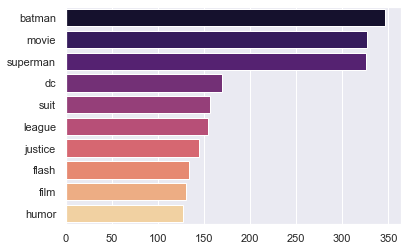

In [90]:
dc_top_ten = dc_word_count.most_common(10)
words_dc= [x[0] for x in dc_top_ten]
count_dc= [x[1] for x in dc_top_ten]

sns.barplot(x =count_dc, y =words_dc, palette= 'magma');

As Stopwords were already added during the Marvel Dataset exploration, I believe some of the words were already removed by the stopwords.

Similar to how the Marvel Dataset looks. Majority of these words relate to heroes or something with-in its domain of DC_Cinematics 

### Comparing both Dataset Plots

#### Top words Marvel Vs DC

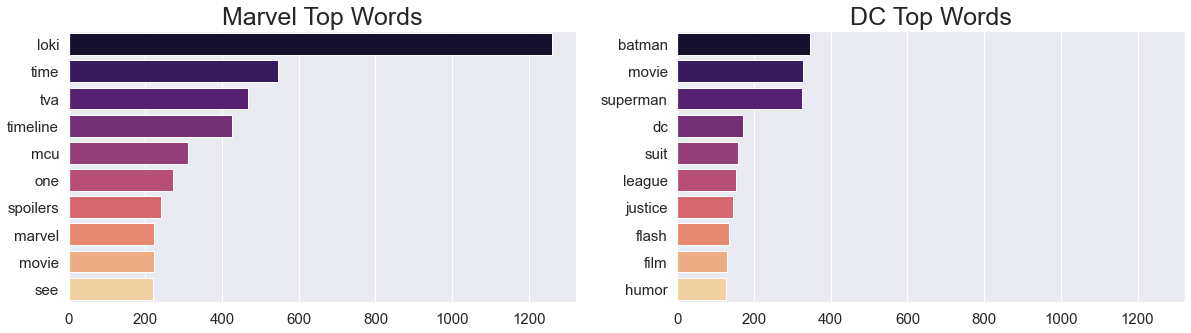

In [91]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,5))

axes[0].set_title('Marvel Top Words',fontsize = 25)
axes[0].tick_params(labelsize=15)
sns.barplot(ax=axes[0],x =count_marvel, y =words_marvel, palette= 'magma');

axes[1].set_title('DC Top Words',fontsize = 25)
axes[1].tick_params(labelsize=15)
sns.barplot(ax=axes[1],x =count_dc, y =words_dc, palette= 'magma');


#### Unique Words DC Vs Marvel

In [92]:
#Total Number of words Marvel
print(f'Marvel has a total of {len(marvel_freq_count)} words')
#Total Number of words DC
print(f'DC has a total of {len(dc_freq_count)} words')

Marvel has a total of 41604 words
DC has a total of 21600 words


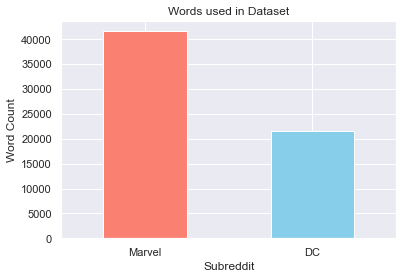

In [93]:
#Visualize total number of words
pd.Series([len(marvel_freq_count),len(dc_freq_count) ], index=['Marvel','DC']).plot(kind="bar",color = ('salmon','skyblue'))

plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Words used in Dataset")
plt.xlabel("Subreddit")
plt.ylabel("Word Count");

In [94]:
#Finding Unique Words Marvel
marvel = []

count_marvel = 0

for item in marvel_freq_count:
    if item not in marvel:
        count_marvel += 1
        marvel.append(item)
        
#Finding Unique Words DC
dc = []

count_dc = 0

for item in dc_freq_count:
    if item not in dc:
        count_dc += 1
        dc.append(item)

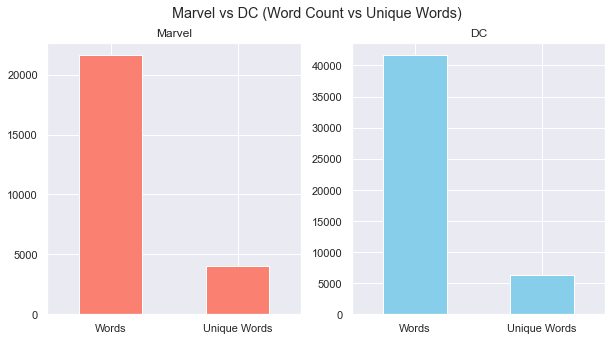

In [95]:
#Comparing both Data Unique Words
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Marvel vs DC (Word Count vs Unique Words)')

axes[1].set_title('DC')
pd.Series([len(dc_freq_count),len(dc)], index=['Words','Unique Words']).plot(ax=axes[0],rot=0,kind="bar",color = 'salmon')

axes[0].set_title('Marvel')
pd.Series([len(marvel_freq_count),len(marvel)], index=['Words','Unique Words']).plot(ax=axes[1],rot=0,kind="bar",color = 'skyblue');

DC has a higher ratio of unique words compared to Marvel. Which makes gives I believe allows the model to have an easier time to train and classify in the modelling phase.

In [96]:
def Intersection(marvel, dc):
    return set(marvel).intersection(dc)

print(len(Intersection(marvel_freq_count, dc_freq_count)))

2090


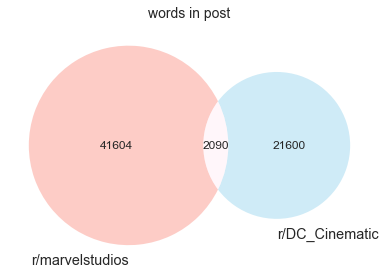

In [97]:
#Finding Common words
venn2(subsets = (len(marvel_freq_count),len(dc_freq_count),len(Intersection(marvel_freq_count, dc_freq_count))), 
      set_labels = ('r/marvelstudios', 'r/DC_Cinematic'),set_colors = ('salmon','skyblue'))
plt.title('words in post', fontsize=14)
plt.tight_layout()

We can see a total of 2090 words are commonly shared between both datasets. Another point which will assist our model in the upcoming phase

### Joining words back for modelling & dropping not required columns

In [98]:
#Joining words back for each row in Lemmatized column
for i in df_marvel_clean['lem'].index:
    df_marvel_clean['lem'][i] = ' '.join(df_marvel_clean['lem'][i])
#Joining words back for each row in Tokenized column
for i in df_marvel_clean['tokens'].index:
    df_marvel_clean['tokens'][i] = ' '.join(df_marvel_clean['tokens'][i])

In [99]:
df_marvel_clean.head(5)

,subreddit,combined,tokens,lem
0,1,rewatching is very different after endgame n...,rewatching is very different after endgame now...,rewatching is very different after endgame now...
1,1,widowBlack Widow (Avengers) on set of black wi...,widowBlack Widow Avengers on set of black wido...,widowblack widow avengers on set of black wido...
2,1,sorry if im late to the game but is that a '...,sorry if im late to the game but is that Loki ...,sorry if im late to the game but is that loki ...
3,1,a jeopardy contestant guessed thor ragnarok ...,jeopardy contestant guessed thor ragnarok for ...,jeopardy contestant guessed thor ragnarok for ...
4,1,the moon knight show what do yall think of i...,the moon knight show what do yall think of it ...,the moon knight show what do yall think of it ...


In [100]:
#Joining words back for each row in Lemmatized column
for i in df_dc_clean['lem'].index:
    df_dc_clean['lem'][i] = ' '.join(df_dc_clean['lem'][i])
#Joining words back for each row in Tokenized column
for i in df_dc_clean['tokens'].index:
    df_dc_clean['tokens'][i] = ' '.join(df_dc_clean['tokens'][i])

In [101]:
df_dc_clean.head(5)

,subreddit,combined,tokens,lem
0,0,social media the rock says cool thing dropp...,social media the rock says cool thing dropping...,social medium the rock say cool thing dropping...
1,0,article in treatment star quintessa swindel...,article in treatment star quintessa swindell o...,article in treatment star quintessa swindell o...
2,0,humor i posted this earlier but forgot to f...,humor posted this earlier but forgot to flair ...,humor posted this earlier but forgot to flair ...
3,0,thats how they got the floating shaky cam [...,thats how they got the floating shaky cam dele...,thats how they got the floating shaky cam dele...
4,0,do you think gal gadot looks like lauren ph...,do you think gal gadot looks like lauren phill...,do you think gal gadot look like lauren philli...


----

## Combine both Datasets for Modelling

In [102]:
df = pd.concat([df_dc_clean,df_marvel_clean])

In [103]:
df['subreddit'].value_counts()

1    1100
0    1100
Name: subreddit, dtype: int64

In [104]:
df.isnull().sum()

subreddit    0
combined     0
tokens       0
lem          0
dtype: int64

In [105]:
#Convert to CSV
df.to_csv('modeldata.csv',index = False)

In [106]:
df.head()

,subreddit,combined,tokens,lem
0,0,social media the rock says cool thing dropp...,social media the rock says cool thing dropping...,social medium the rock say cool thing dropping...
1,0,article in treatment star quintessa swindel...,article in treatment star quintessa swindell o...,article in treatment star quintessa swindell o...
2,0,humor i posted this earlier but forgot to f...,humor posted this earlier but forgot to flair ...,humor posted this earlier but forgot to flair ...
3,0,thats how they got the floating shaky cam [...,thats how they got the floating shaky cam dele...,thats how they got the floating shaky cam dele...
4,0,do you think gal gadot looks like lauren ph...,do you think gal gadot looks like lauren phill...,do you think gal gadot look like lauren philli...


## EDA Summary

From both Marvel and DC datasets, we can see there are clearly more word counts found in the Marvel Dataset.

Both sets suffered from null values due to having only titles and nothing written onto the posts. These null values has either been imputed or combined with the titles to create a more usable dataset

As we are dealing with NLP, we can rule out any outliers as we are taking all words into consideration for our model Training

In conclusion from our EDA, there are words that are distint to each dataset. This gives a high probability we are able to both classify the user as well as recommend our client which hero they should target for their games.

Certain heros that can be recommended are from our top words seen.
- Loki 
- Batman
- Flash
- Superman